In [1]:
import os
os.chdir("..")
#!pip install -r requirements.txt

### Библиотеки

In [2]:
import boto3
from dotenv import dotenv_values
import pandas as pd
from io import StringIO
import numpy as np
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set_style("darkgrid")

from scipy.optimize import minimize, Bounds, NonlinearConstraint
from portfolio_analytics.covariances import rolling_covariance_with_step, expanding_covariance_with_step

from portfolio_analytics.optimizer import Optimizer
from portfolio_analytics.utils import plot_efficient_frontier_curve

import warnings
warnings.filterwarnings('ignore')

config = dotenv_values(".env")

### Данные с S3

In [3]:
session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id = config['s3_aws_access_key_id'],
    aws_secret_access_key = config['s3_aws_secret_access_key']
)

In [4]:
bytes_data = s3.get_object(Bucket='portfoliodata', Key="prepared_data/returns_final.csv")['Body'].read()
csv_data = StringIO(str(bytes_data,'utf-8')) 

data = pd.read_csv(csv_data)
date_data = data.iloc[:,1]
return_data = data.iloc[:,2:]

return_data

,SBER,LKOH,GAZP,AFLT,ROSN,NVTK,MGNT,PLZL,SNGS,CHMF,...,APTK,IRKT,VTBR,GMKN,TGKB,TGKA,SVAV,AFKS,NMTP,MSRS
0,0.016495,-0.008177,-0.000822,0.013493,0.012558,0.005102,-0.000824,0.046834,-0.002328,0.007866,...,0.008994,0.017621,0.000822,0.014640,0.008368,0.000000,0.022682,0.019013,-0.008217,0.003984
1,0.011301,-0.012609,0.009960,0.003879,-0.031310,0.045685,0.045771,0.000829,-0.000986,0.017187,...,-0.013928,-0.003896,0.000000,-0.008259,-0.012448,-0.006270,0.024286,0.091167,-0.007660,0.069048
2,0.002865,-0.015717,0.021888,0.012845,0.002776,0.029029,0.007430,0.038079,0.009605,0.023276,...,-0.008475,-0.000565,-0.006568,0.019318,0.016807,-0.006309,-0.023703,-0.031385,-0.015438,0.013363
3,0.006762,-0.006502,-0.009513,0.013507,-0.009018,-0.009388,-0.013778,0.018963,-0.009514,0.019377,...,0.000000,-0.003348,-0.015702,-0.018071,-0.008264,-0.003175,0.006421,-0.003352,-0.016000,0.021245
4,-0.036988,-0.049709,-0.049384,-0.017803,-0.040499,-0.078051,-0.021324,-0.044436,-0.054605,-0.042975,...,-0.028490,-0.018325,-0.037783,-0.041293,-0.029167,-0.012739,-0.020575,-0.035874,-0.056911,-0.035151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4252,0.027805,0.022611,0.052671,0.023126,0.016152,0.015294,0.016581,0.018551,0.000635,0.022891,...,-0.013151,0.003984,0.035729,0.028963,-0.007317,0.009505,0.015291,0.029904,0.040452,-0.002248
4253,-0.007840,0.002218,-0.009523,0.003281,-0.004897,0.021950,0.029140,0.001968,0.014585,0.010845,...,-0.005923,-0.005952,-0.010323,0.015370,-0.008190,0.002853,-0.003012,-0.004804,-0.013722,0.012618
4254,0.006084,-0.001785,0.007093,0.011083,0.020549,-0.000632,0.006958,0.009856,-0.005417,0.010048,...,-0.006330,0.009980,0.009902,0.012584,-0.008258,0.030441,0.003776,0.013559,0.026667,0.012461
4255,0.006010,0.001073,0.014164,0.049057,0.008460,0.002739,-0.038580,-0.015065,0.010264,0.038779,...,-0.002248,0.029644,0.020918,0.024856,-0.010824,0.026229,0.014296,0.032217,0.009599,0.010989


In [5]:
bytes_data = s3.get_object(Bucket='portfoliodata', Key="stock_meta_data.csv")['Body'].read()
csv_data = StringIO(str(bytes_data,'utf-8')) 
meta_data=pd.read_csv(csv_data).iloc[:,1:]
meta_data

,id,secid,shortname,regnumber,name,isin,is_traded,emitent_id,emitent_title,emitent_inn,emitent_okpo,gosreg,type,group,primary_boardid,marketprice_boardid
0,424433251,ABIO,iАРТГЕН ао,1-01-08902-A,"ПАО ""Артген""",RU000A0JNAB6,1,1142.0,"Публичное акционерное общество ""Артген биотех""",7.702509e+09,71328785.0,1-01-08902-A,common_share,stock_shares,TQBR,TQBR
1,12441,ABRD,АбрауДюрсо,1-02-12500-A,Абрау-Дюрсо ПАО ао,RU000A0JS5T7,1,4787.0,"Публичное акционерное общество ""Абрау – Дюрсо""",7.727621e+09,81521198.0,1-02-12500-A,common_share,stock_shares,TQBR,TQBR
2,2699,AFKS,Система ао,1-05-01669-A,"АФК ""Система"" ПАО ао",RU000A0DQZE3,1,777.0,"Публичное акционерное общество ""Акционерная фи...",7.703105e+09,27987276.0,1-05-01669-A,common_share,stock_shares,TQBR,TQBR
3,2700,AFLT,Аэрофлот,1-01-00010-A,Аэрофлот-росс.авиалин(ПАО)ао,RU0009062285,1,1242.0,"Публичное акционерное общество ""Аэрофлот – рос...",7.712040e+09,29063984.0,1-01-00010-A,common_share,stock_shares,TQBR,TQBR
4,76079,AGRO,AGRO-гдр,NaN,ГДР ROS AGRO PLC ORD SHS,US7496552057,1,7502.0,ROS AGRO PLC,1.003487e+07,NaN,NaN,depositary_receipt,stock_dr,TQBR,TQBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,8151,ziop,"АО ""ЗиО-Подольск""",1-01-04090-A,"Акционерное общество ""Машиностроительный завод...",RU000A0JQ6B5,0,3685.0,"Акционерное общество ""Машиностроительный завод...",5.036041e+09,NaN,1-01-04090-A,common_share,stock_shares,EQNE,NaN
2413,7778,ZIRE,ЗИРЕРА ао,1-01-57303-D,"""ЗИРЕРА"" ОАО - ао",RU000A0JRFT8,0,4518.0,"Открытое акционерное общество ""ЗИРЕРА""",1.655203e+09,68734469.0,1-01-57303-D,common_share,stock_shares,TQNE,NaN
2414,3898,ZMZN,ЗМЗ-ао,1-01-00230-A,Заволжский мотор.з-д ПАО ао,RU0009101539,0,1004.0,"Публичное акционерное общество ""Заволжский мот...",5.248004e+09,NaN,1-01-00230-A,common_share,stock_shares,TQBR,TQBR
2415,3899,ZMZNP,ЗМЗ-ап,2-01-00230-A,Заволжский мотор.завод ПАО ап,RU0006752854,0,1004.0,"Публичное акционерное общество ""Заволжский мот...",5.248004e+09,NaN,2-01-00230-A,preferred_share,stock_shares,TQBR,TQBR


### Анализ влияния ограничений в optimizer на границу эффективных портфелей

#### Задание 4

In [ ]:
test_data_1_year = return_data.iloc[:252,:]

#### Задание 5

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

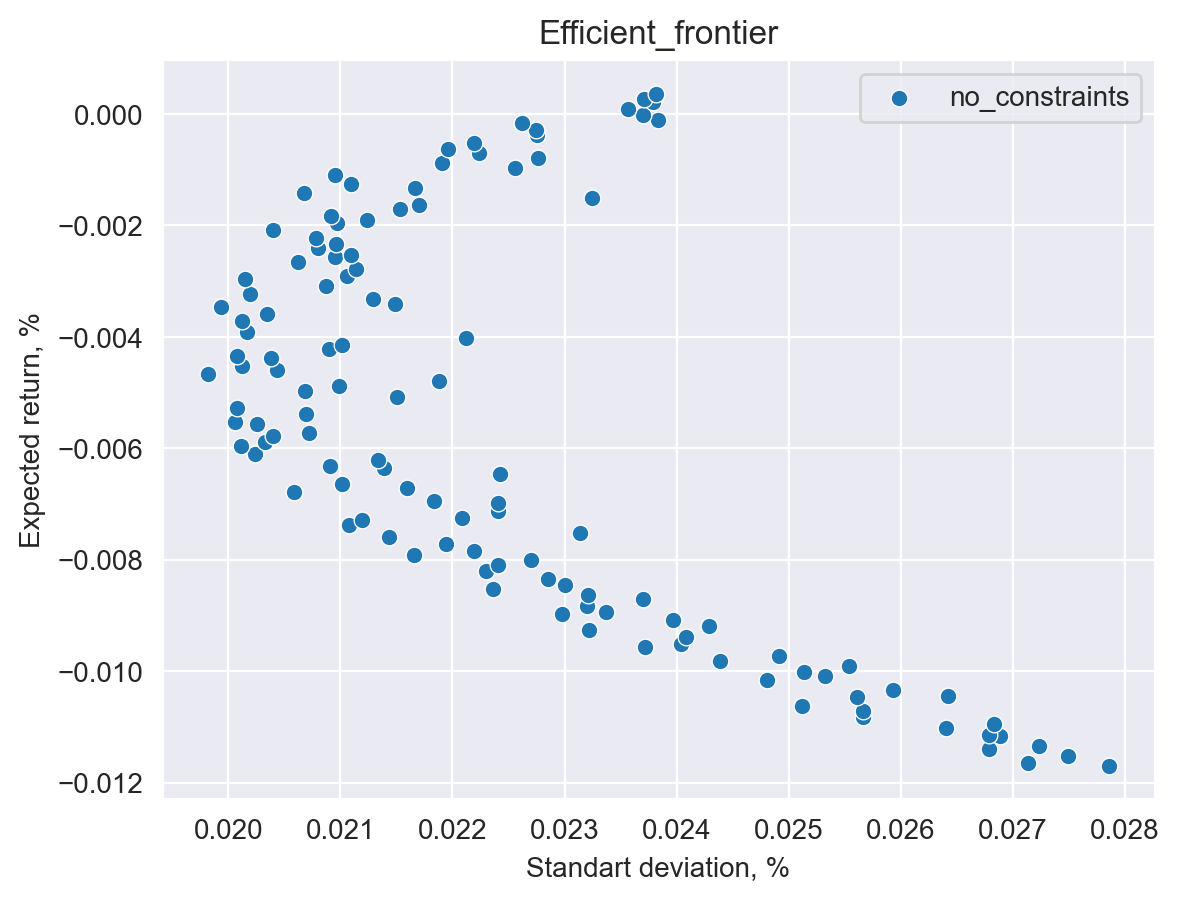

In [9]:
optim = Optimizer(test_data_1_year)
res_5 = optim.efficient_frontier_curve()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_5], [x[0] for x in res_5], label='no_constraints', ax=ax)

#### Задание 6

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

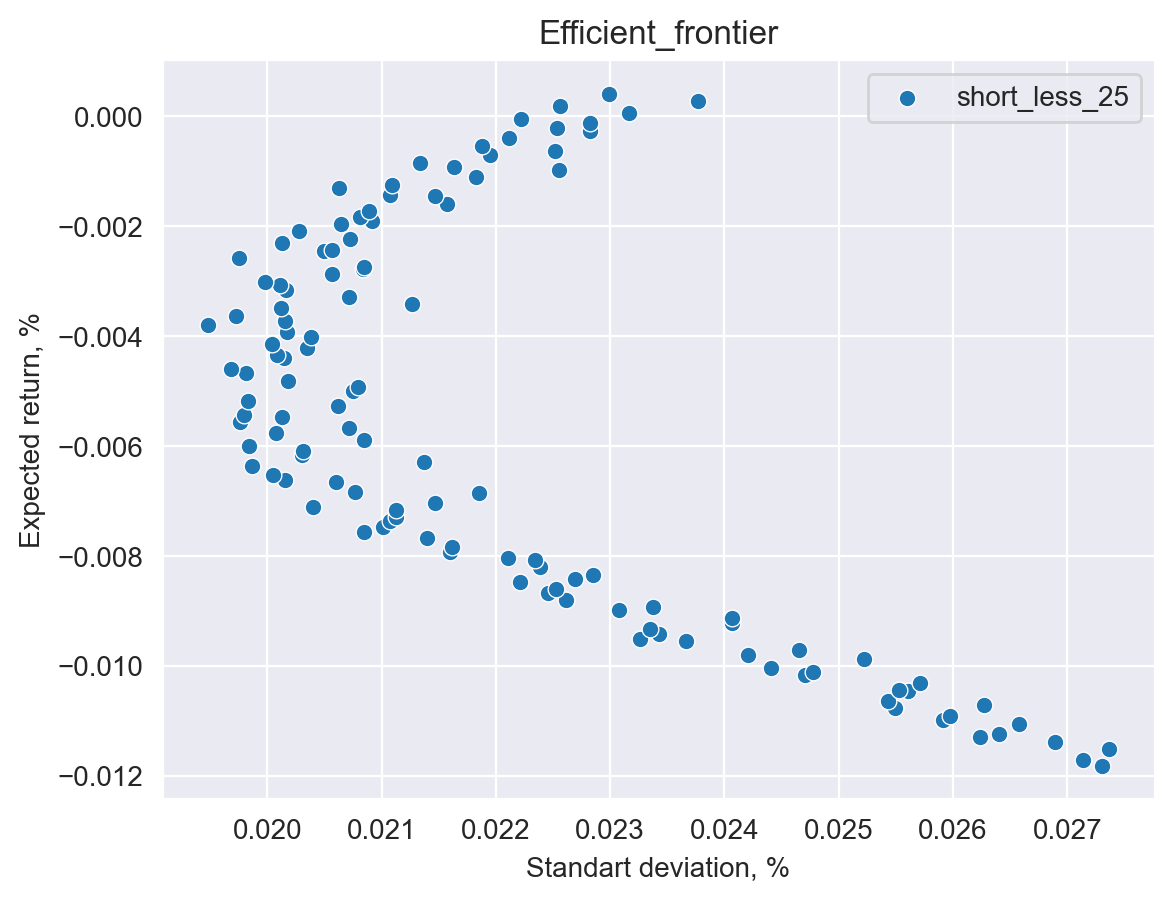

In [14]:
n_shares = test_data_1_year.shape[1]
short_less_25 = Bounds(np.zeros(n_shares)-0.25, np.ones(n_shares)) 

optim = Optimizer(test_data_1_year, bounds=short_less_25)
res_6 = optim.efficient_frontier_curve()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_6], [x[0] for x in res_6], label='short_less_25', ax=ax)

#### Задание 7

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

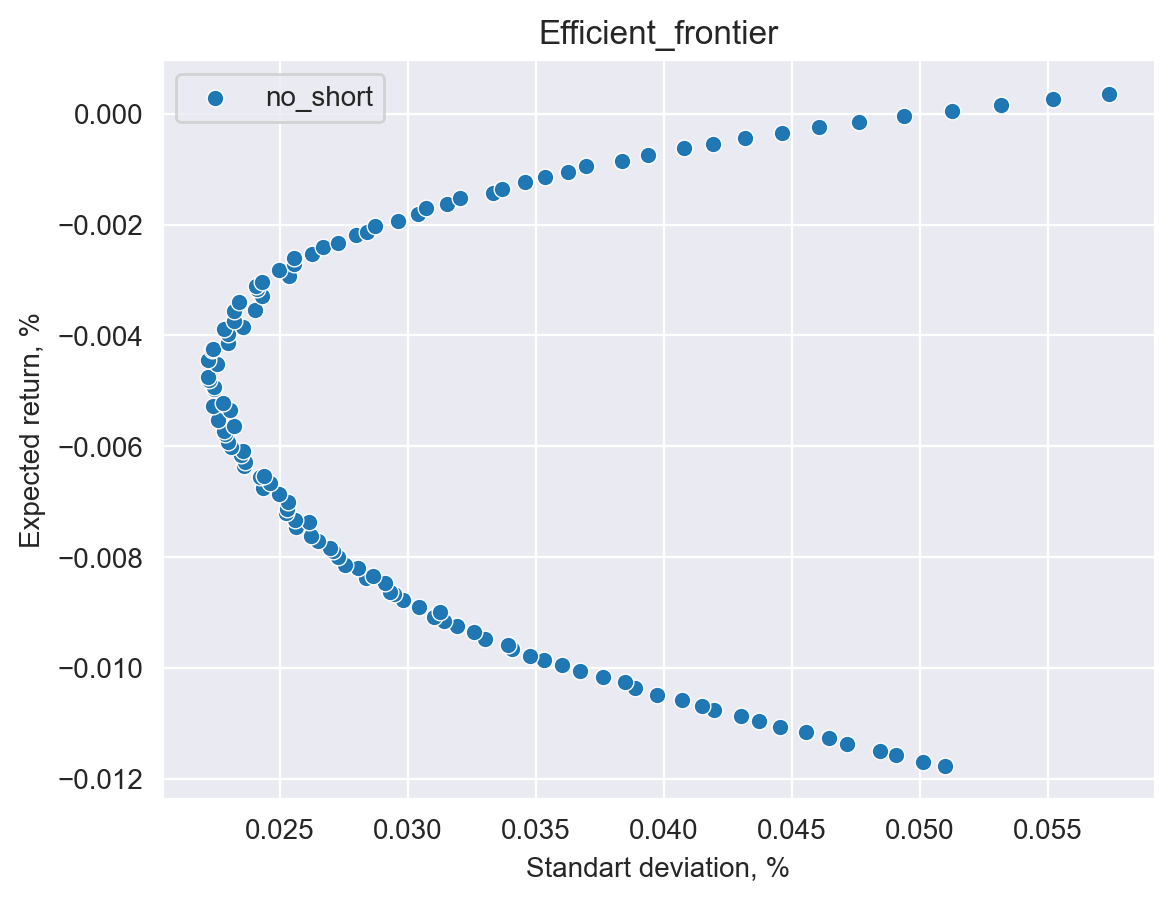

In [11]:
n_shares = test_data_1_year.shape[1]
no_short_bound = Bounds(np.zeros(n_shares), np.ones(n_shares)) 

optim = Optimizer(test_data_1_year, bounds=no_short_bound)
res_7 = optim.efficient_frontier_curve()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_7], [x[0] for x in res_7], label='no_short', ax=ax)

#### Задание 8

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

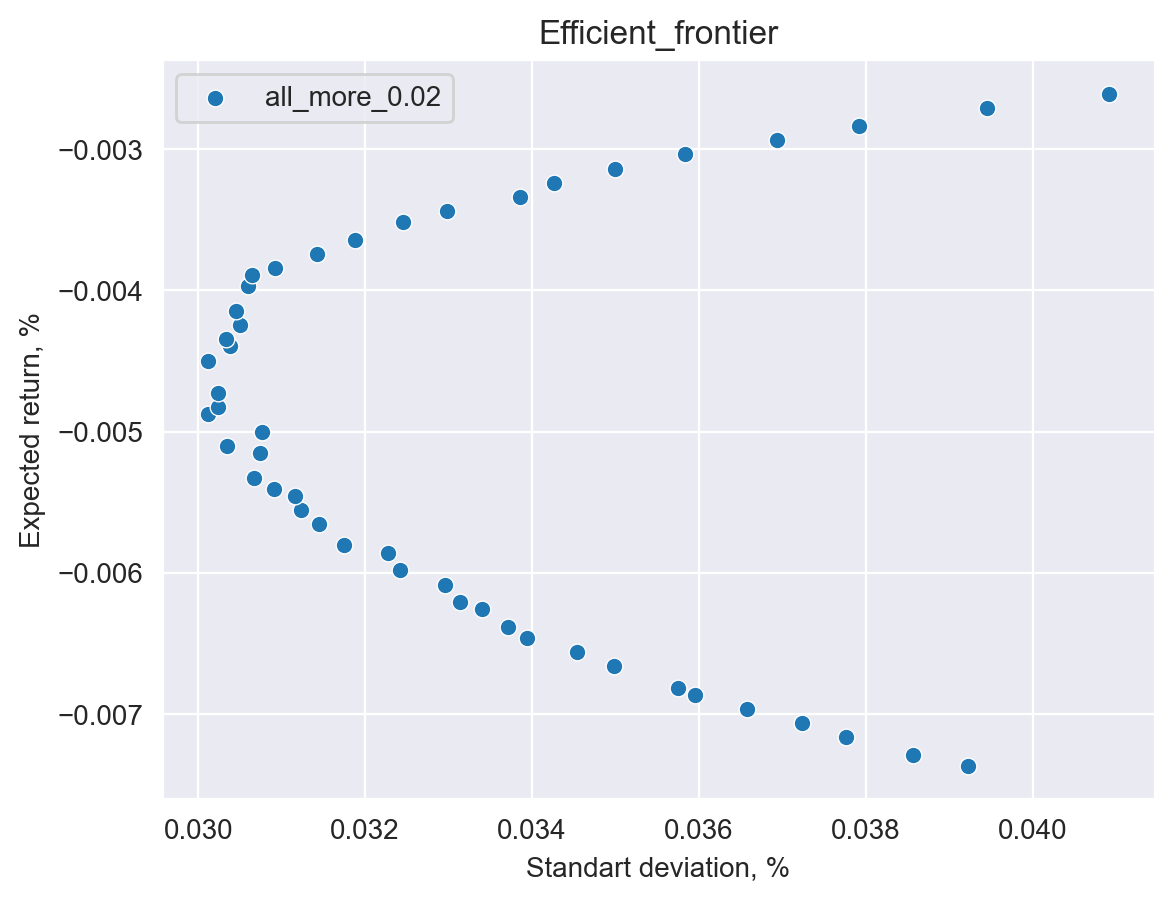

In [12]:
n_shares = test_data_1_year.shape[1]
min_bound = Bounds(np.zeros(n_shares)+0.02, np.ones(n_shares)) 

optim = Optimizer(test_data_1_year, bounds=min_bound)
res_8 = optim.efficient_frontier_curve()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_8], [x[0] for x in res_8], label='all_more_0.02', ax=ax)

<Figure size 800x800 with 0 Axes>

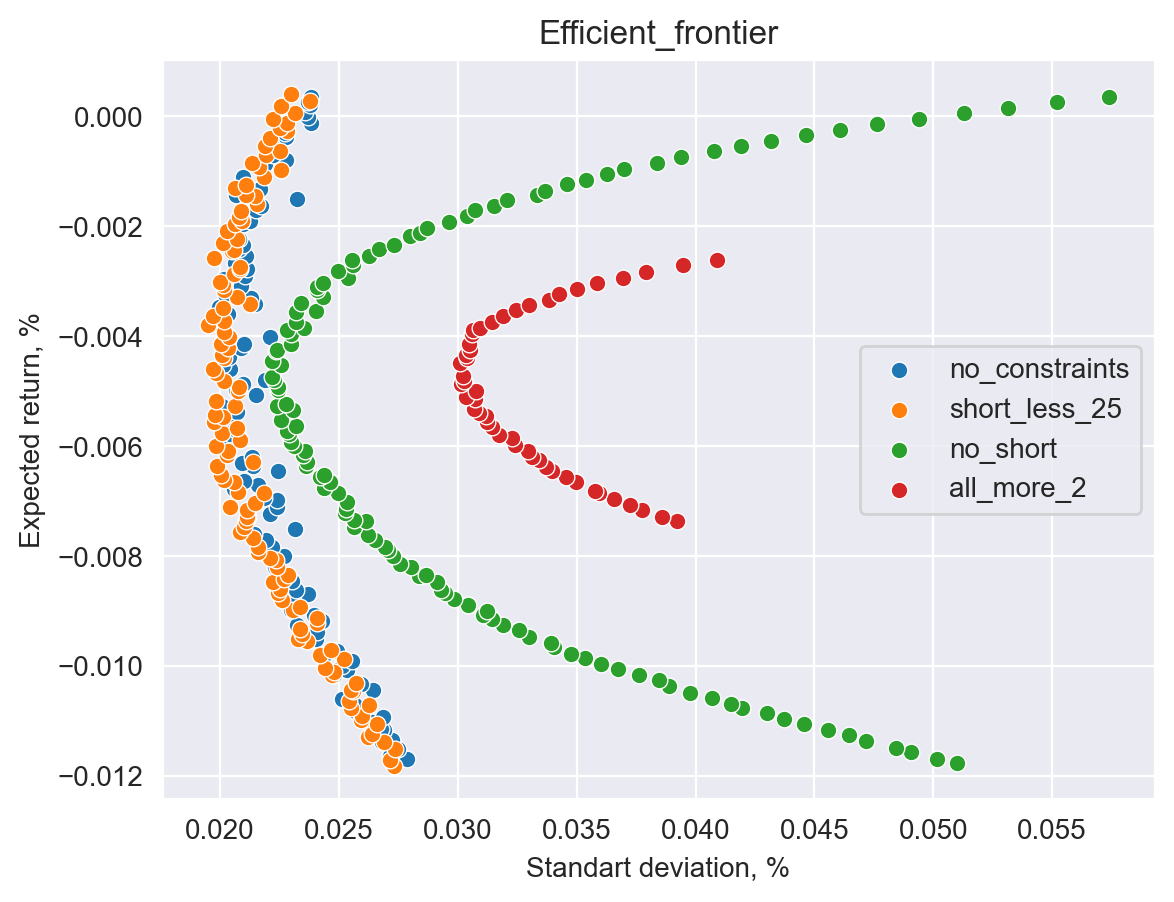

In [15]:
#сравнение предыдущих пунктов
plt.figure(figsize=(8,8))
fig, ax = plt.subplots()

plot_efficient_frontier_curve([x[1] for x in res_5], [x[0] for x in res_5], label='no_constraints', ax=ax)
plot_efficient_frontier_curve([x[1] for x in res_6], [x[0] for x in res_6], label='short_less_25', ax=ax)
plot_efficient_frontier_curve([x[1] for x in res_7], [x[0] for x in res_7], label='no_short', ax=ax)
plot_efficient_frontier_curve([x[1] for x in res_8], [x[0] for x in res_8], label='all_more_2', ax=ax)

#### Задание 9

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

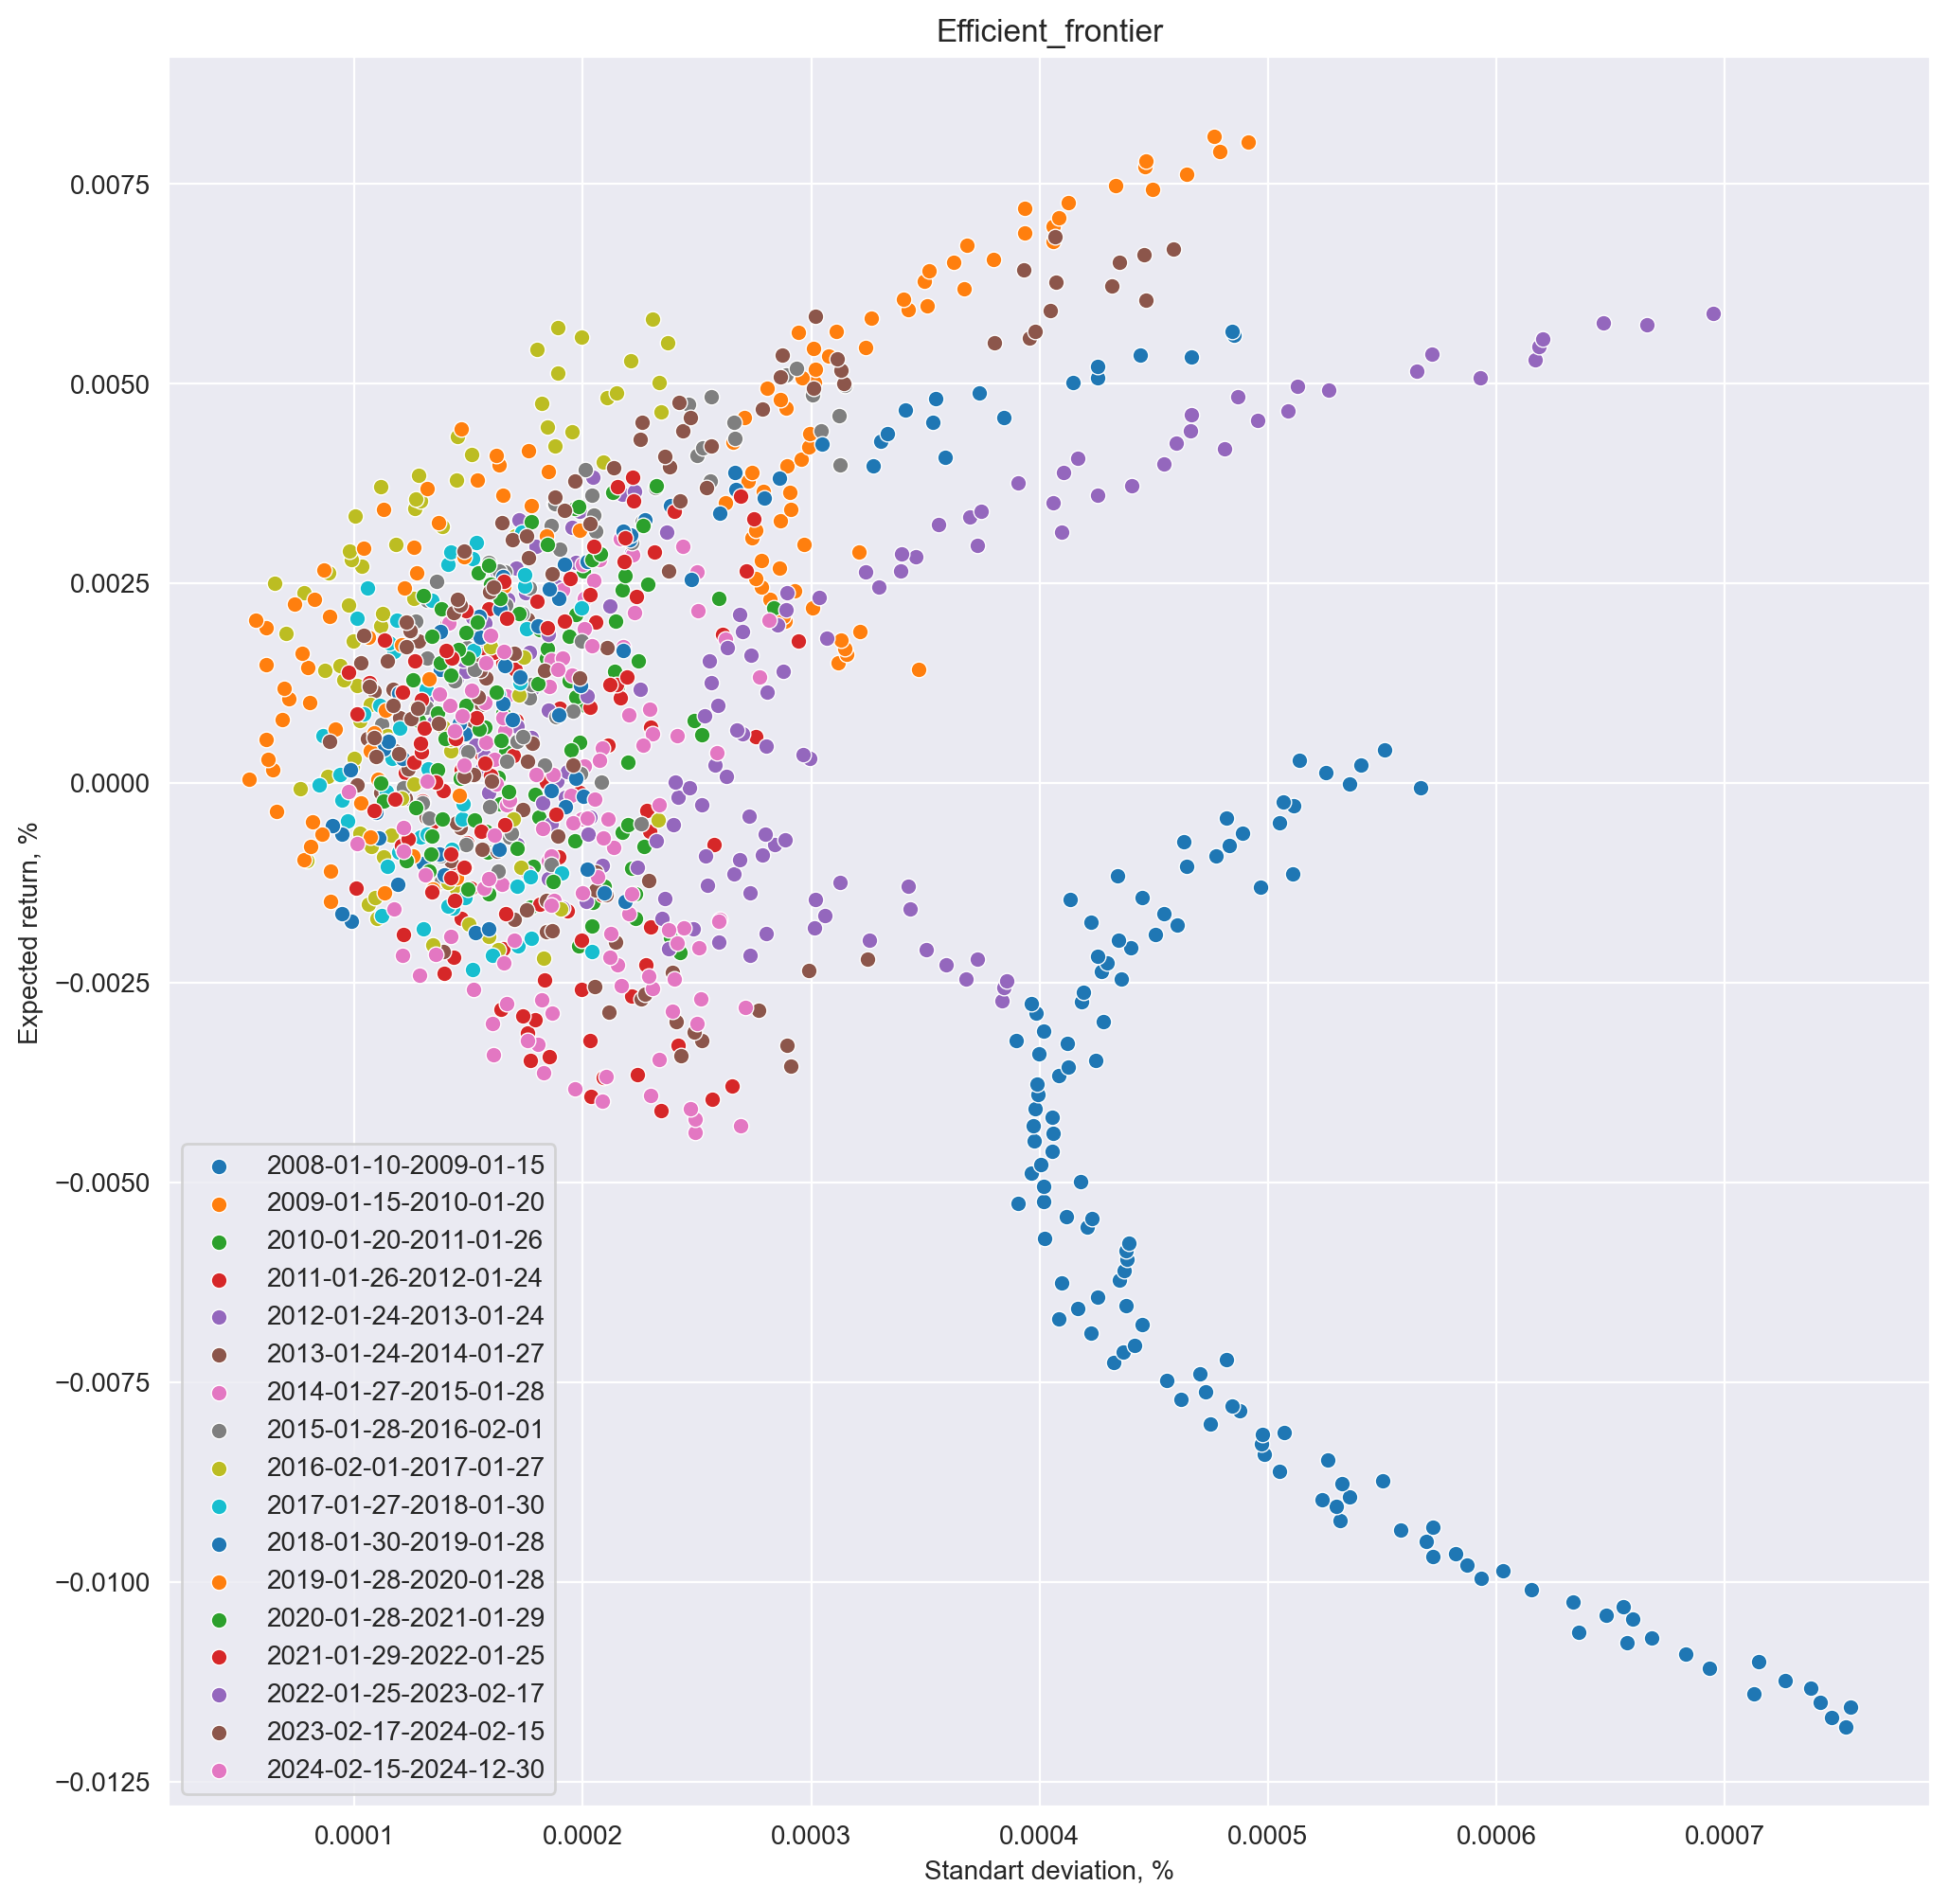

In [16]:
steps = 252
window = 252

fig, ax = plt.subplots(figsize=(12,12))
for step in tqdm(range(0, len(return_data), steps)):
    df_returns_sclice = return_data.iloc[step:window+step]

    optim = Optimizer(df_returns_sclice)
    res_slice = optim.efficient_frontier_curve(n_point=1000)

    if len(res_slice) == 0:
        continue

    plot_efficient_frontier_curve([x[1] for x in res_slice], [x[0] for x in res_slice], label=f'{date_data[step]}-{date_data[min(window+step, len(date_data)-1)]}', ax=ax)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

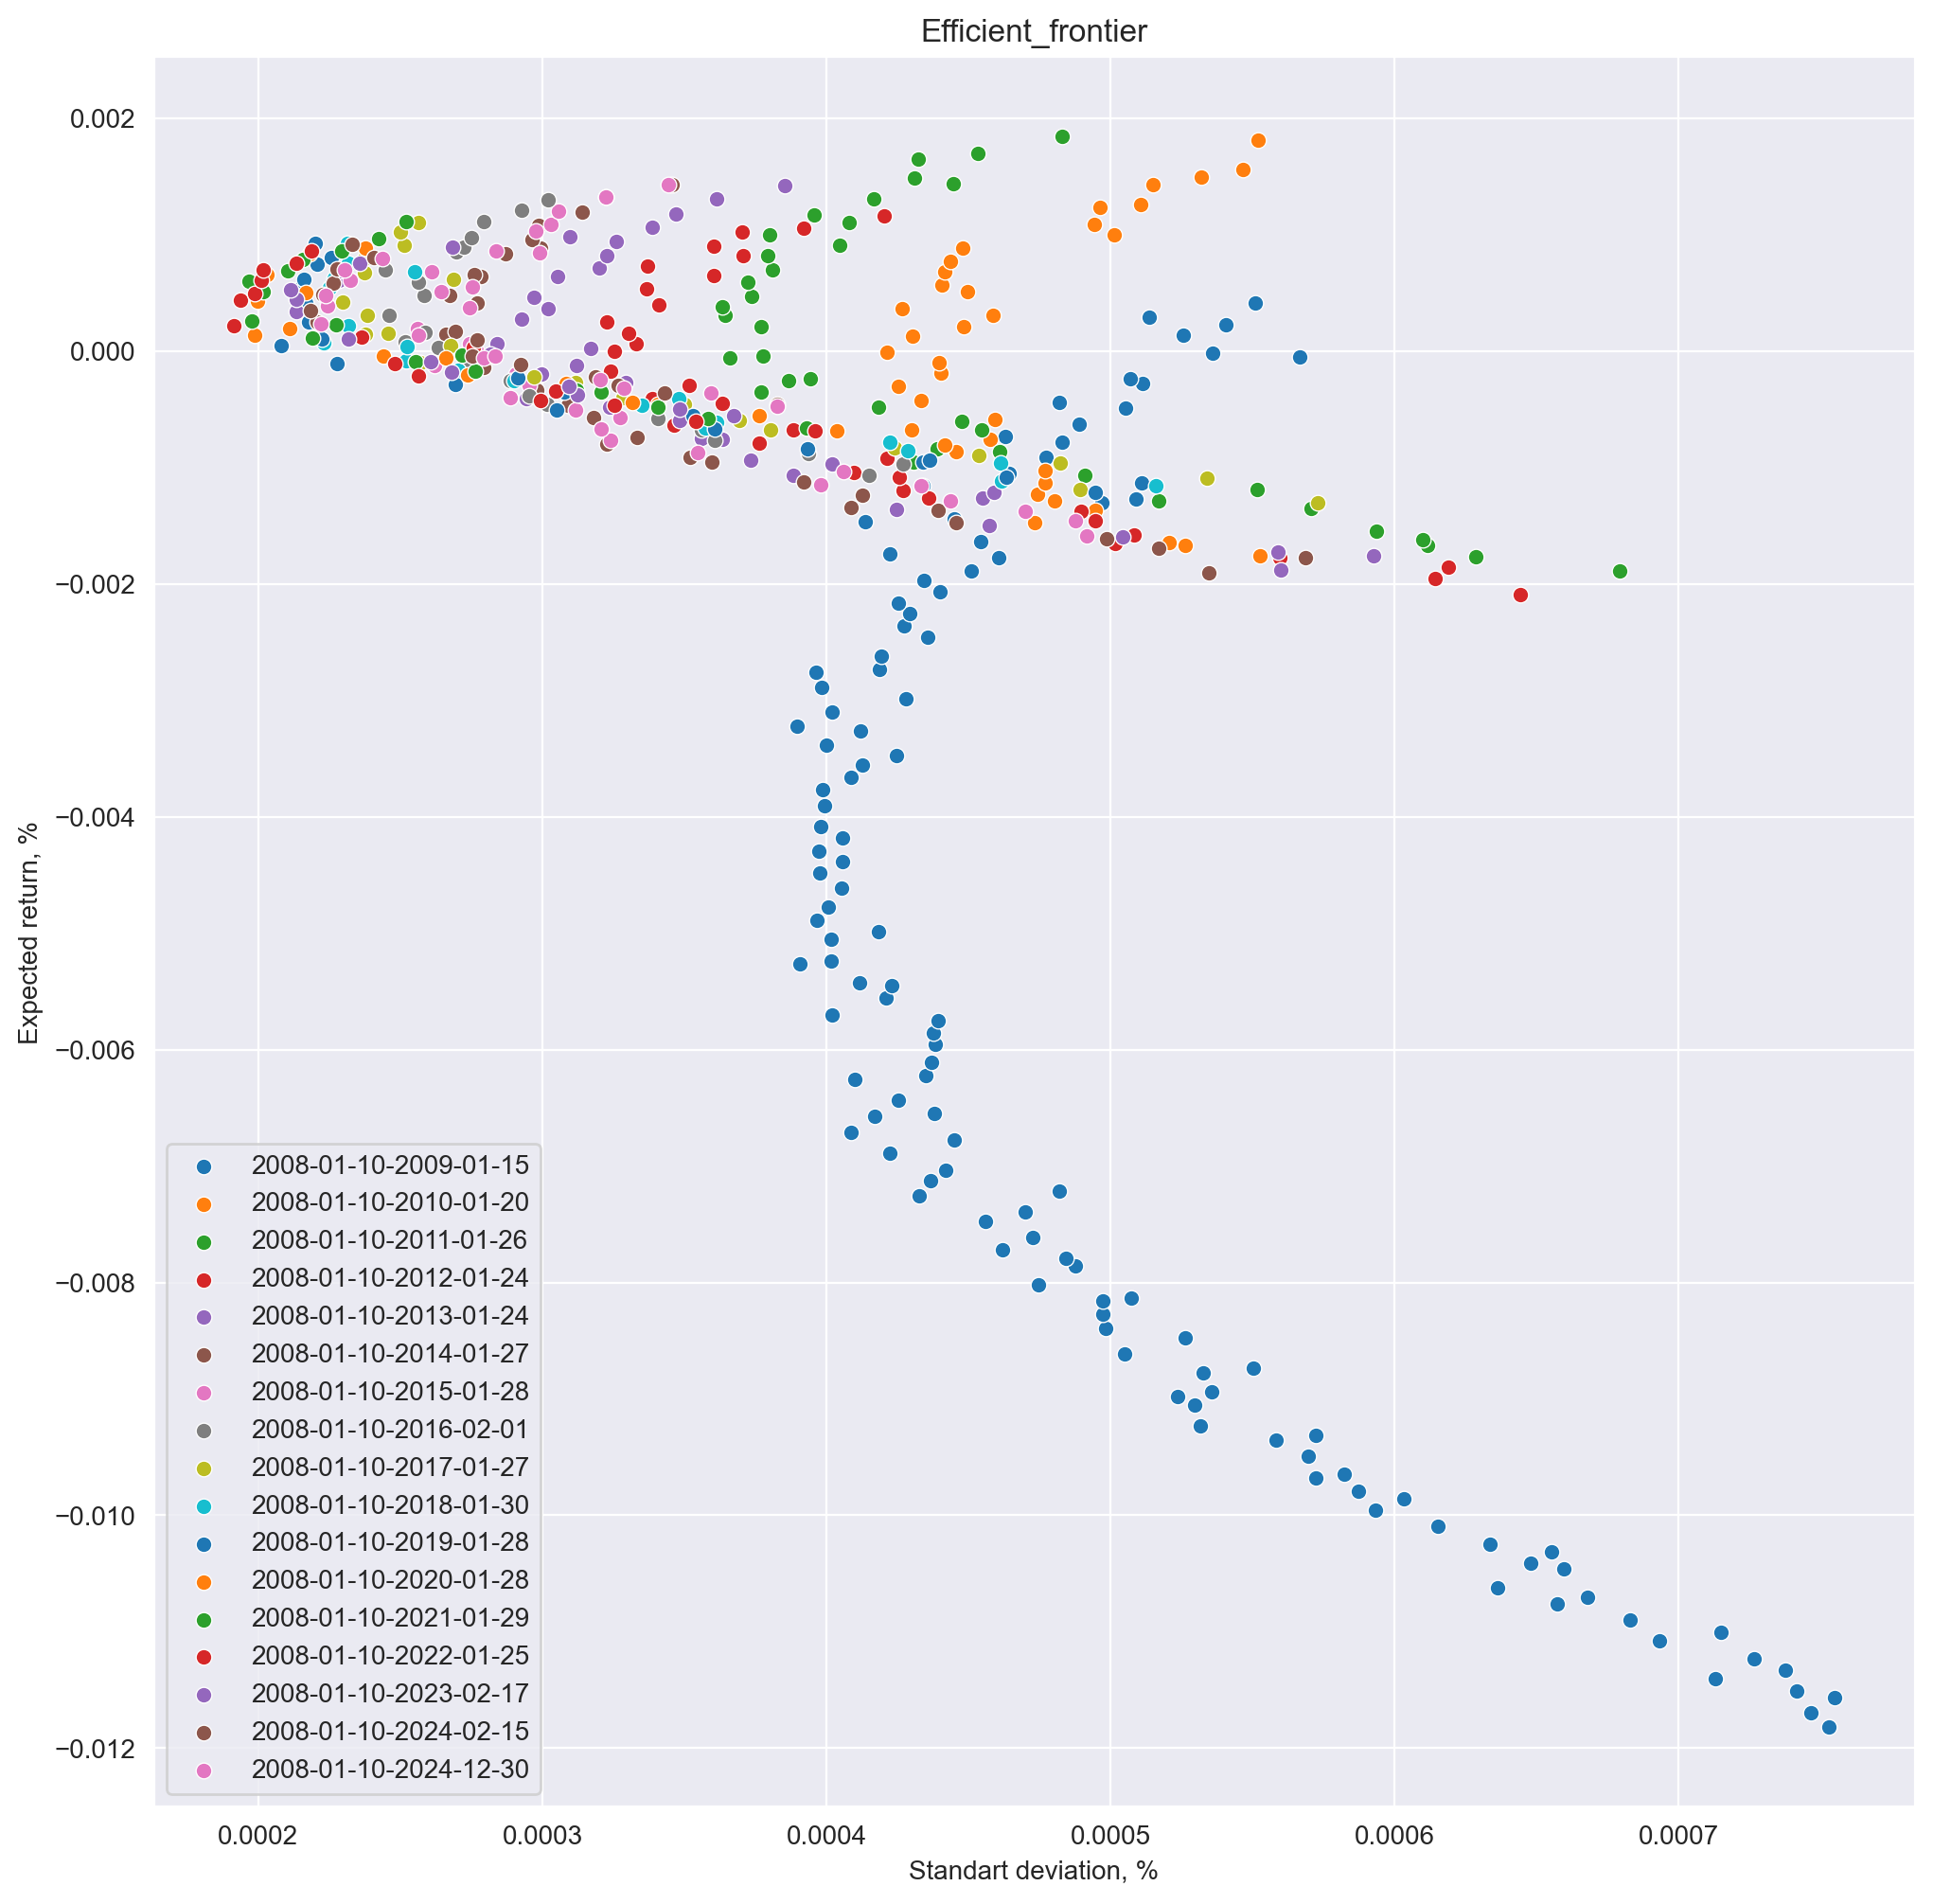

In [17]:
steps = 252
window = 252

fig, ax = plt.subplots(figsize=(12,12))
for step in tqdm(range(0, len(return_data), steps)):
    df_returns_sclice = return_data.iloc[0:window+step]

    optim = Optimizer(df_returns_sclice)
    res_slice = optim.efficient_frontier_curve(n_point=1000)

    if len(res_slice) == 0:
        continue

    plot_efficient_frontier_curve([x[1] for x in res_slice], [x[0] for x in res_slice], label=f'{date_data[0]}-{date_data[min(window+step, len(date_data)-1)]}', ax=ax)

#### Задание 10

In [24]:
cov_roll = rolling_covariance_with_step(
    return_data,
    step=252,
    window_size=252,
    cov_method='exp_cov'
    )[0]

In [29]:
cov_roll.keys()

dict_keys([252, 504, 756, 1008, 1260, 1512, 1764, 2016, 2268, 2520, 2772, 3024, 3276, 3528, 3780, 4032])

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyError: 4284

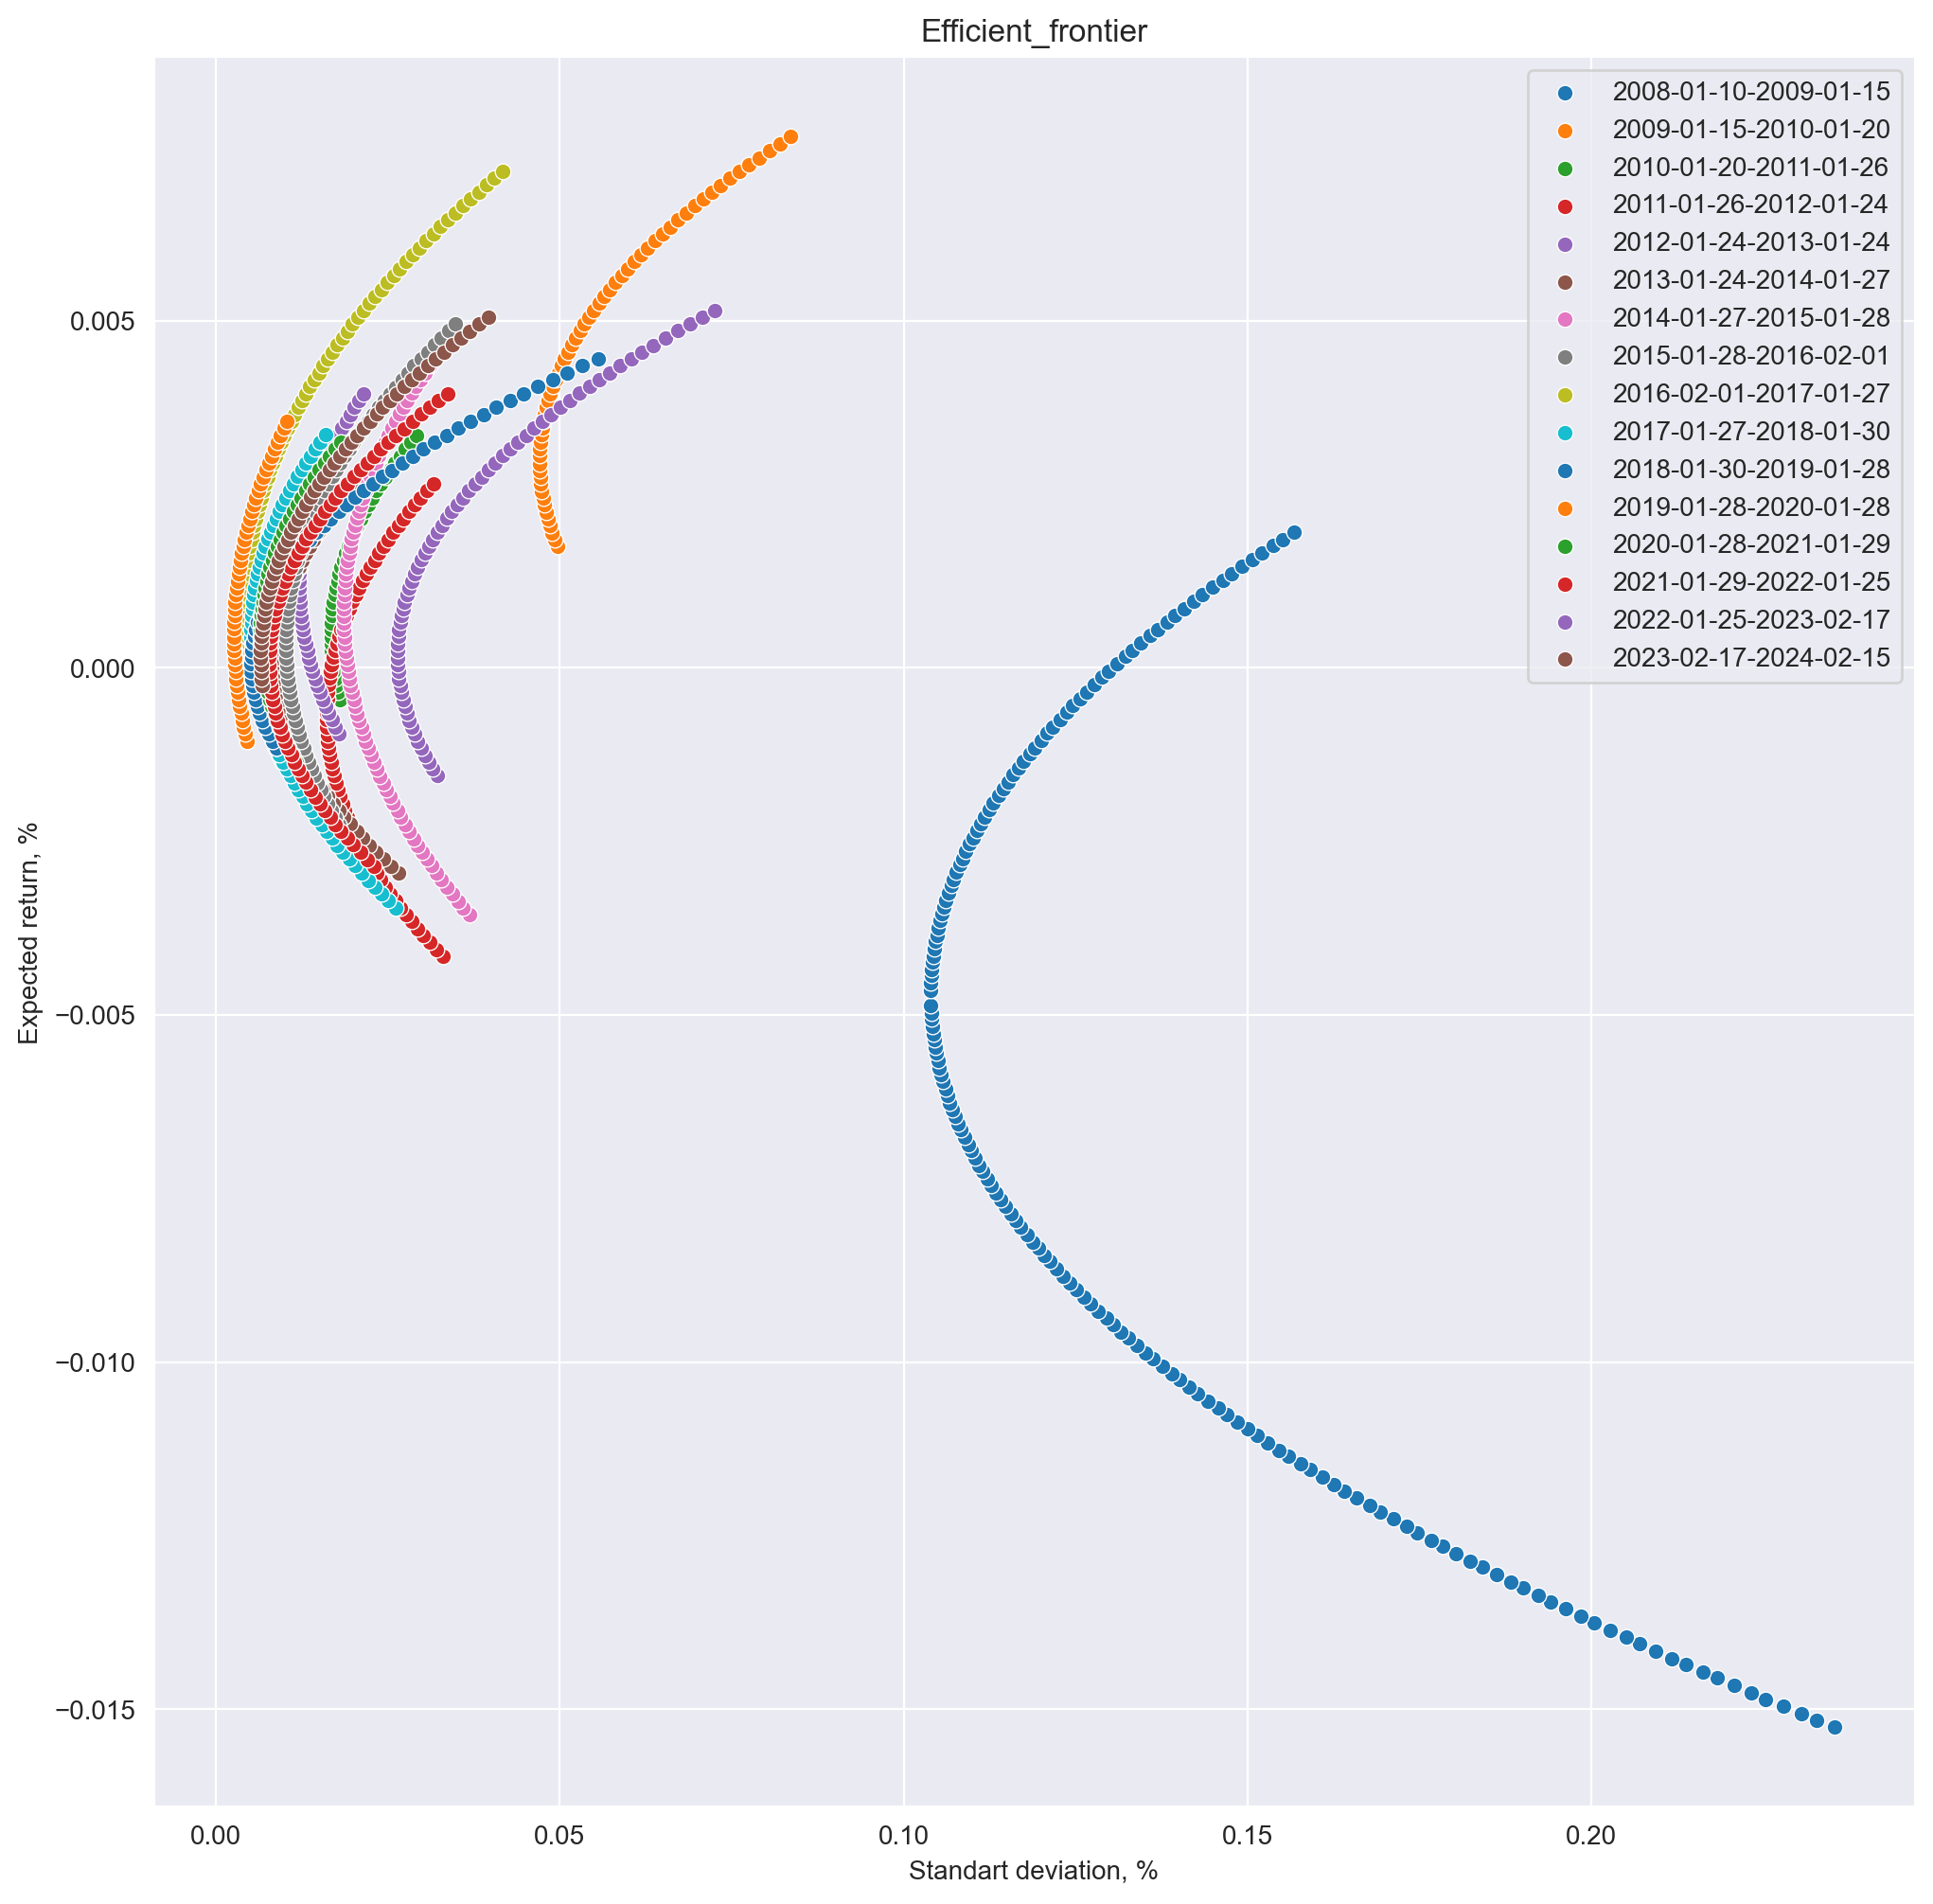

In [28]:
steps = 252
window = 252

fig, ax = plt.subplots(figsize=(12,12))
for step in tqdm(range(0, len(return_data), steps)):
    df_returns_sclice = return_data.iloc[step:window+step]

    optim = Optimizer(df_returns_sclice, mean_return=cov_roll[window+step]['mu'], cov_return=cov_roll[window+step]['cov'])
    res_slice = optim.efficient_frontier_curve(n_point=1000)

    if len(res_slice) == 0:
        continue

    plot_efficient_frontier_curve([x[1] for x in res_slice], [x[0] for x in res_slice], label=f'{date_data[step]}-{date_data[min(window+step, len(date_data)-1)]}', ax=ax)

In [31]:
expand_cov_roll = expanding_covariance_with_step(
    return_data,
    step=252,
    cov_method='exp_cov'
    )

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyError: 4284

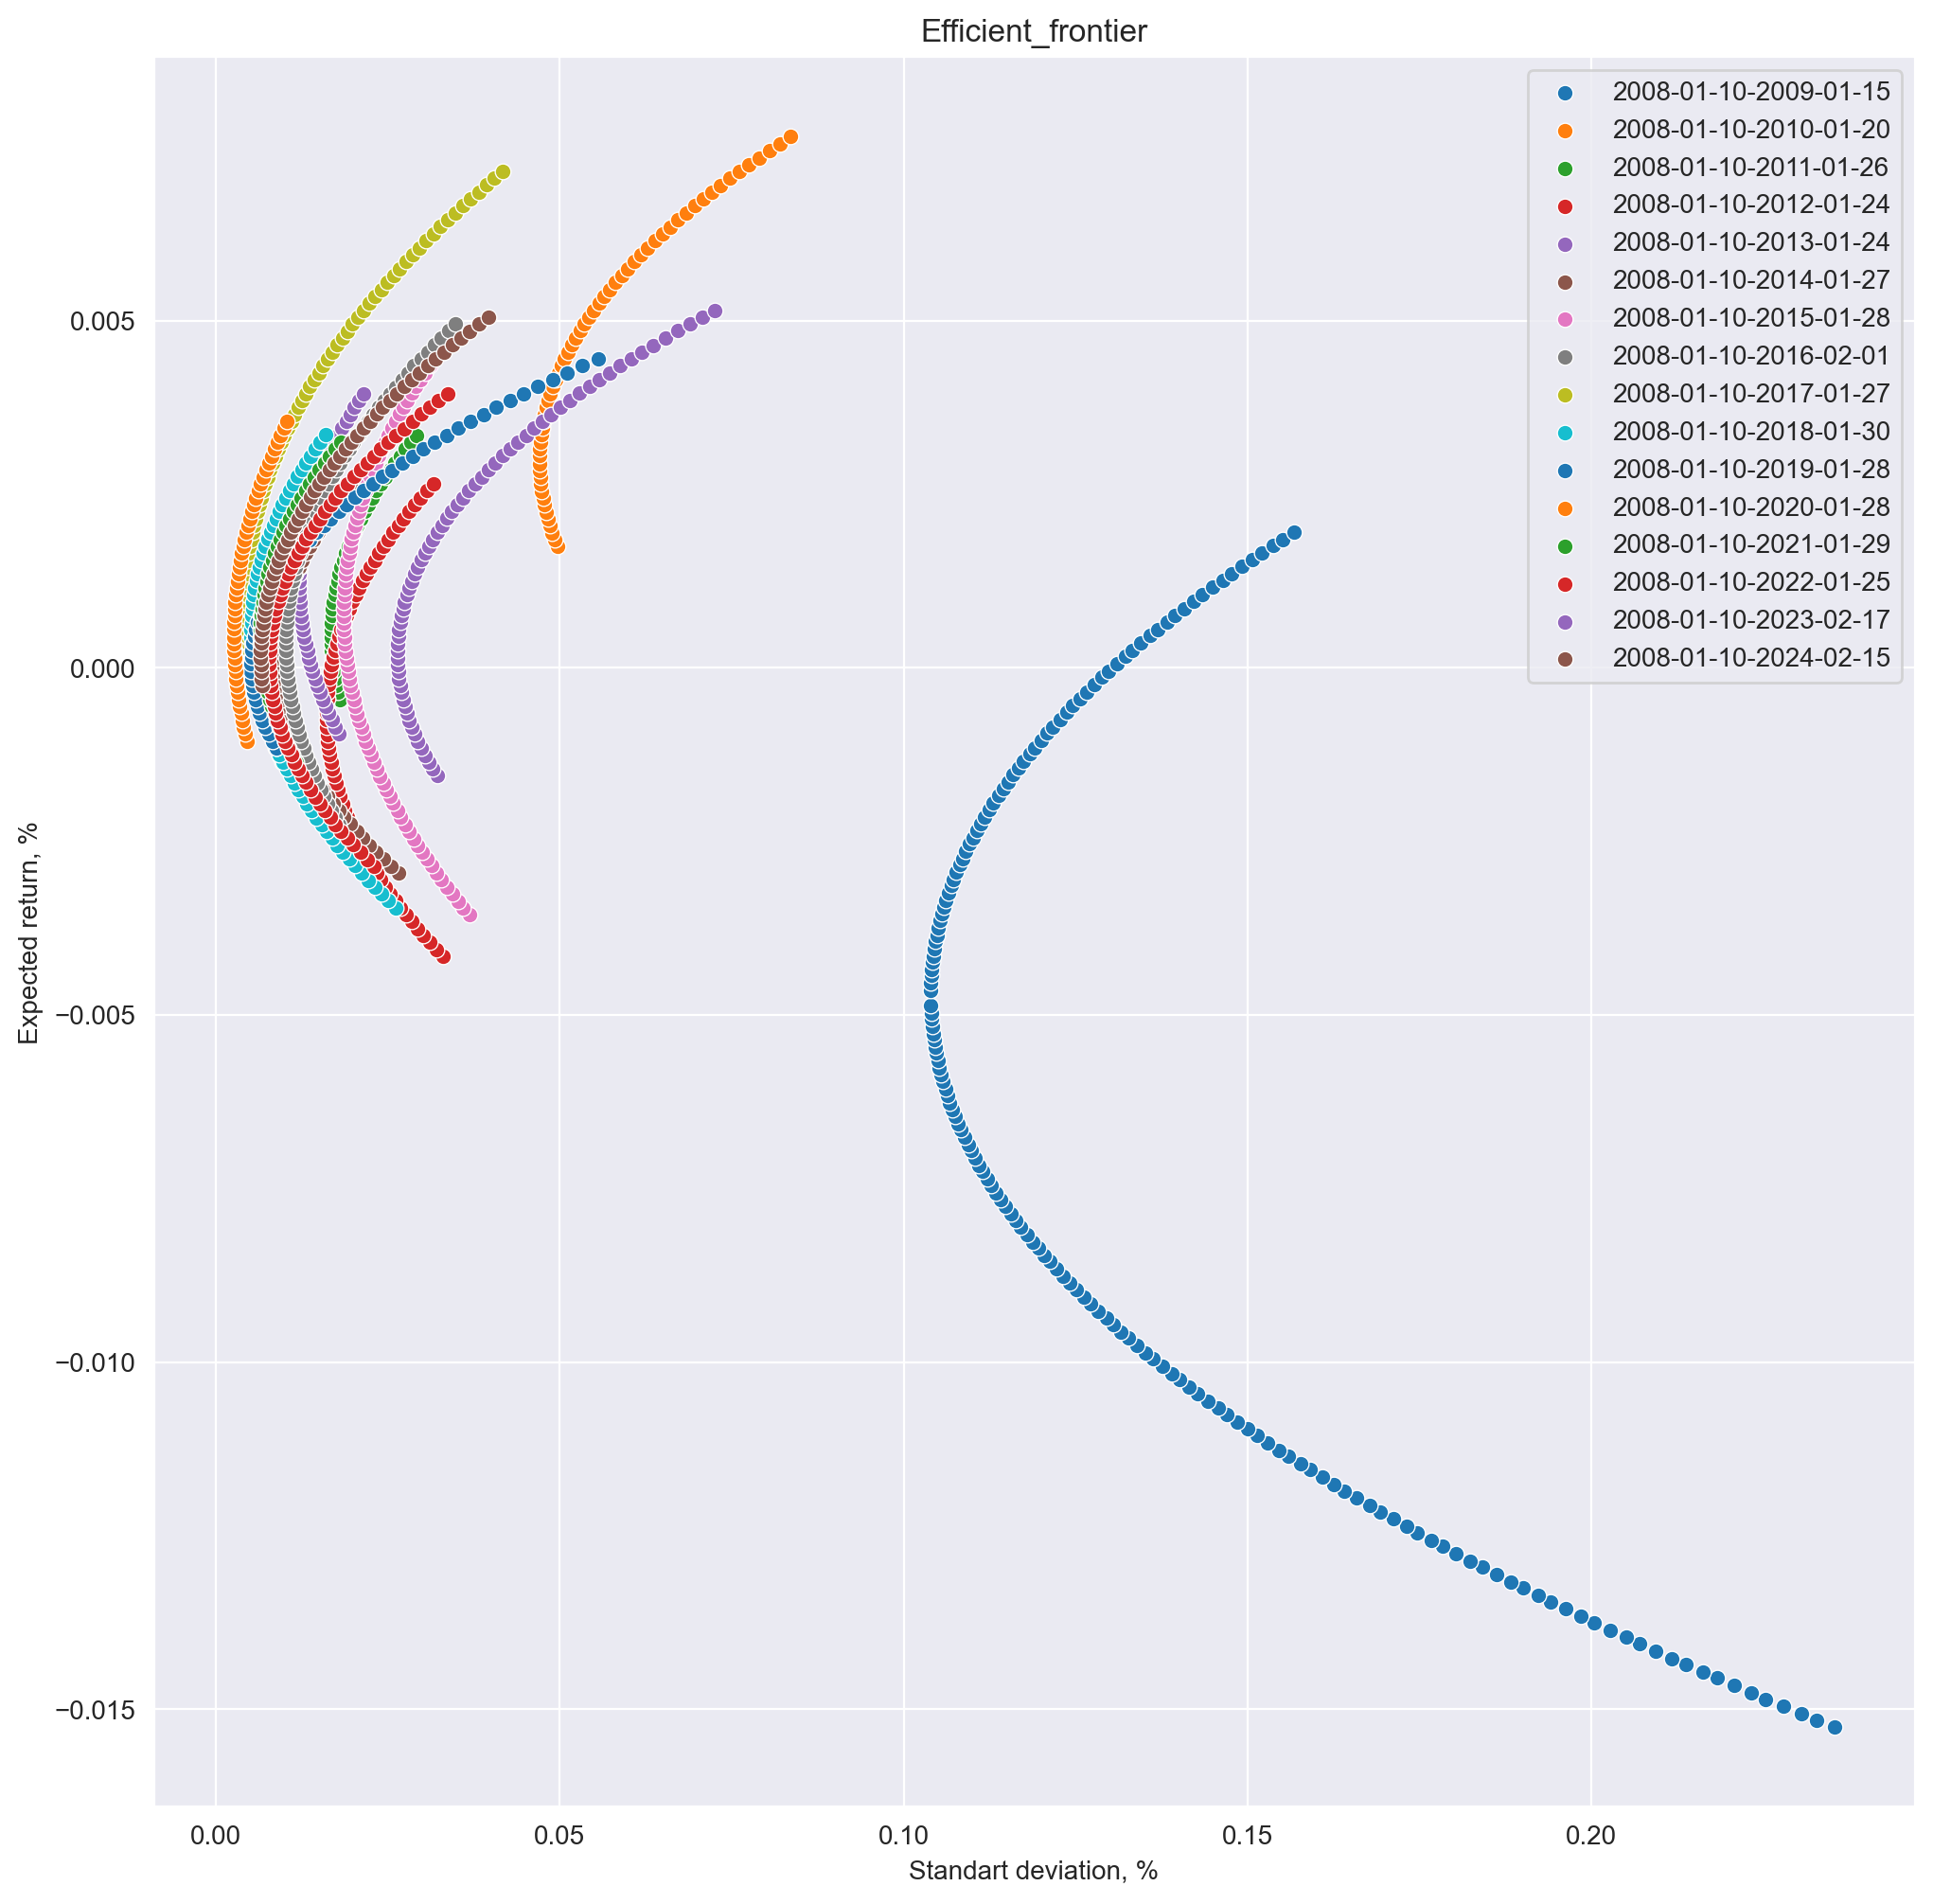

In [ ]:
steps = 252
window = 252

fig, ax = plt.subplots(figsize=(12,12))
for step in tqdm(range(0, len(return_data), steps)):
    df_returns_sclice = return_data.iloc[0:window+step]

    optim = Optimizer(df_returns_sclice, mean_return=expand_cov_roll[window+step]['mu'], cov_return=expand_cov_roll[window+step]['cov'])
    res_slice = optim.efficient_frontier_curve(n_point=1000)

    if len(res_slice) == 0:
        continue

    plot_efficient_frontier_curve([x[1] for x in res_slice], [x[0] for x in res_slice], label=f'{date_data[0]}-{date_data[min(window+step, len(date_data)-1)]}', ax=ax)

### Задание 11

In [ ]:
# date_df = pd.DataFrame(stock_data['begin'])
# index_data = pd.read_csv("IMOEX.csv", delimiter=';') # https://www.investing.com/indices/mcx-historical-data
# imoex_date = pd.merge(date_df, index_data, how='left', on='begin')
# imoex_date['IMOEX'] = imoex_date['IMOEX'].str.replace(',', '.').astype(float)
# csv_data = imoex_date.to_csv(index=False).encode('utf-8')
# s3.put_object(
#     Bucket='portfoliodata',
#     Key=f'IMOEX.csv',
#     Body=csv_data
# )

### Задание 22

In [23]:
optim = Optimizer(test_data_1_year)
data = optim.efficient_frontier_curve(presicion=3)

  0%|          | 0/500 [00:00<?, ?it/s]

In [24]:
total_portfolio = len(data)
cov_matrix = test_data_1_year.cov()
mean_target = test_data_1_year.mean()

In [18]:
np.random.seed(42)

results_df = pd.DataFrame({
    "p1":[], 
    "p2":[], 
    "p_target":[], 
    "alpha":[], 
    "beta":[], 
    "r_taget":[], 
    "std_targer":[],
    "r_rep":[], 
    "std_rep":[],
    "success":[]
})

n_exp = 10000
for i in tqdm(range(n_exp)):

    # семплируем рандомные 3 порфеля
    idx1, idx2, idx3 = np.random.choice([x for x in range (total_portfolio)], 3, replace=False)

    # берем веса первых двух
    w_1 = data[idx1][2]
    w_2 = data[idx2][2]

    # восстанавливаем третий
    r_target = data[idx3][0]
    std_target = data[idx3][1]

    def portfolio_var(coef):
        "Отклонение текущего портфеоя от таргетного"
        w = w_1 * coef[0] + w_2 * coef[1]
        w_matrix = w.reshape(-1, 1) @ w.reshape(1, -1)
        total_var = (w_matrix * cov_matrix).sum().sum()
        return np.abs(total_var - std_target) * 10000

    def expect_return(coef):
        "Проверка на равенстве ожидаемой доходности"
        w = w_1 * coef[0] + w_2 * coef[1]
        r = (mean_target * w).sum()
        return r


    expect_return_constr = NonlinearConstraint(expect_return, r_target, r_target)
    constr = [expect_return_constr]

    best_res = None
    best_score = 1e6
    for _ in range(5):
        init_coef = np.random.uniform(-1, 1, 2)
        res = minimize(
            portfolio_var, 
            x0=init_coef, 
            method='SLSQP', 
            tol=1e-10, 
            constraints=constr,
            options={
                "maxiter":10000
            })
        if res.fun <= best_score:
            best_score = res.fun
            best_res = res
    
    # валидация и логирование результатов
    w_rep = best_res.x[0] * w_1 + best_res.x[1] * w_2
    r_rep = expect_return(best_res.x)
    std_rep = Optimizer.portfolio_var(w_rep, cov_matrix)
    success = 1 * best_res.success if abs((std_target - std_rep) / std_target) <= 0.1 else 0
    results_df.loc[len(results_df)] = [idx1, idx2, idx3, best_res.x[0], best_res.x[1], r_target, std_target, r_rep, std_rep, success]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
results_df

,p1,p2,p_target,alpha,beta,r_taget,std_targer,r_rep,std_rep,success
0,9.0,11.0,0.0,0.125178,7.866282,-0.011645,0.027137,-0.011645,0.027137,1.0
1,1.0,5.0,4.0,-6.948780,11.984876,-0.007592,0.021438,-0.007592,0.021438,1.0
2,10.0,9.0,4.0,-15.523170,11.511025,-0.007592,0.021438,-0.007592,0.021438,1.0
3,13.0,2.0,5.0,-6.065815,0.384602,-0.006787,0.020587,-0.006787,0.020587,1.0
4,5.0,4.0,2.0,16.110234,-13.142439,-0.009556,0.023714,-0.009556,0.023714,1.0
...,...,...,...,...,...,...,...,...,...,...
9995,2.0,4.0,13.0,11.812922,-14.935346,0.000513,0.024051,0.000513,0.024051,1.0
9996,8.0,5.0,3.0,12.457248,-5.749393,-0.008524,0.022364,-0.008524,0.022364,1.0
9997,3.0,2.0,12.0,-16.377973,14.626550,-0.000167,0.022616,-0.000167,0.022616,1.0
9998,11.0,5.0,1.0,-9.744776,3.610168,-0.010613,0.025122,-0.010613,0.025122,1.0


In [20]:
results_df['success'].mean()

0.9968